
Analyzing Rural Areas
Training XGBoost Model for pm2_5 (μg/m³)...


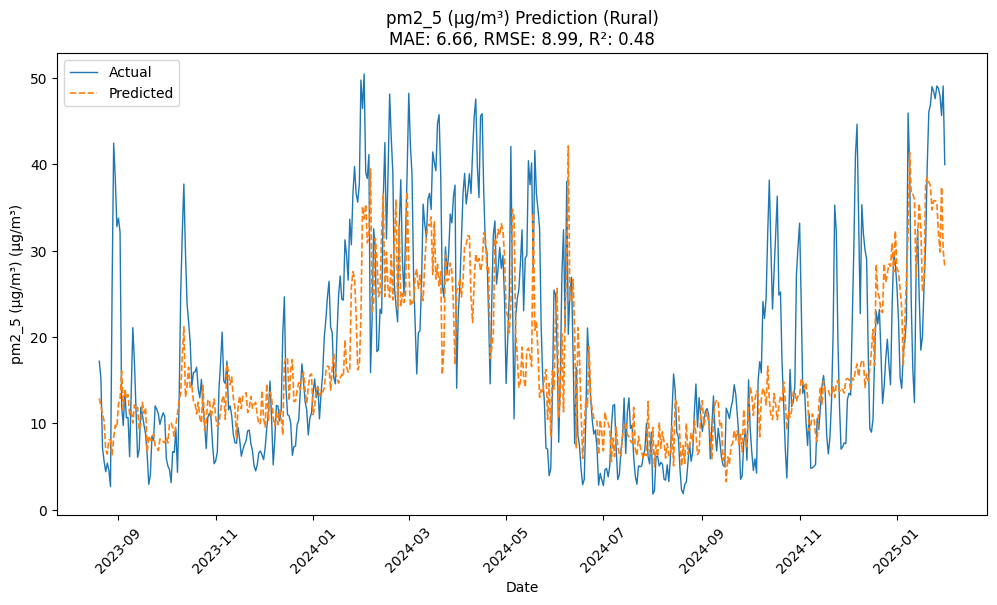

Training XGBoost Model for pm10 (μg/m³)...


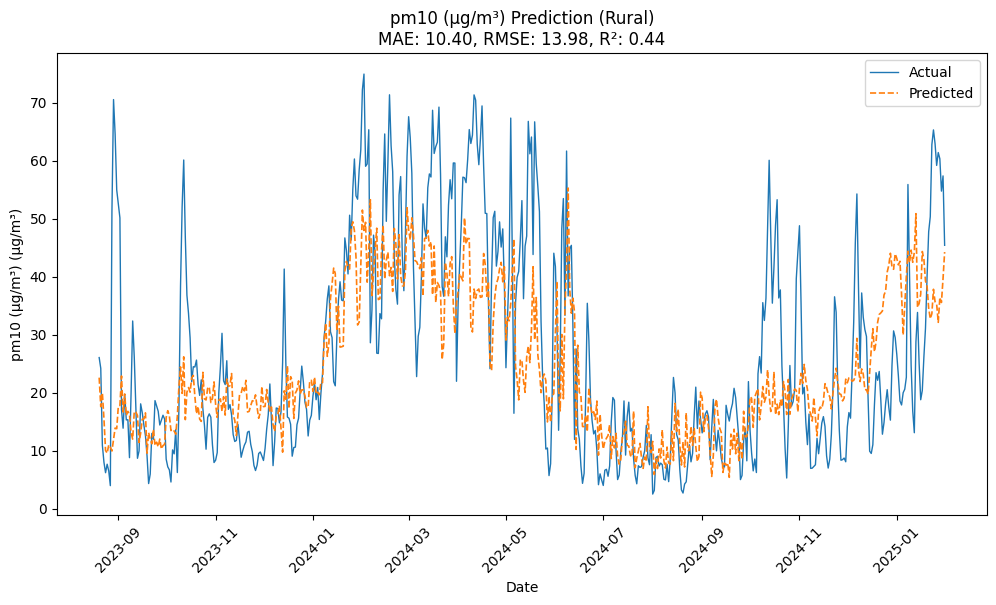

Training XGBoost Model for carbon_monoxide (μg/m³)...


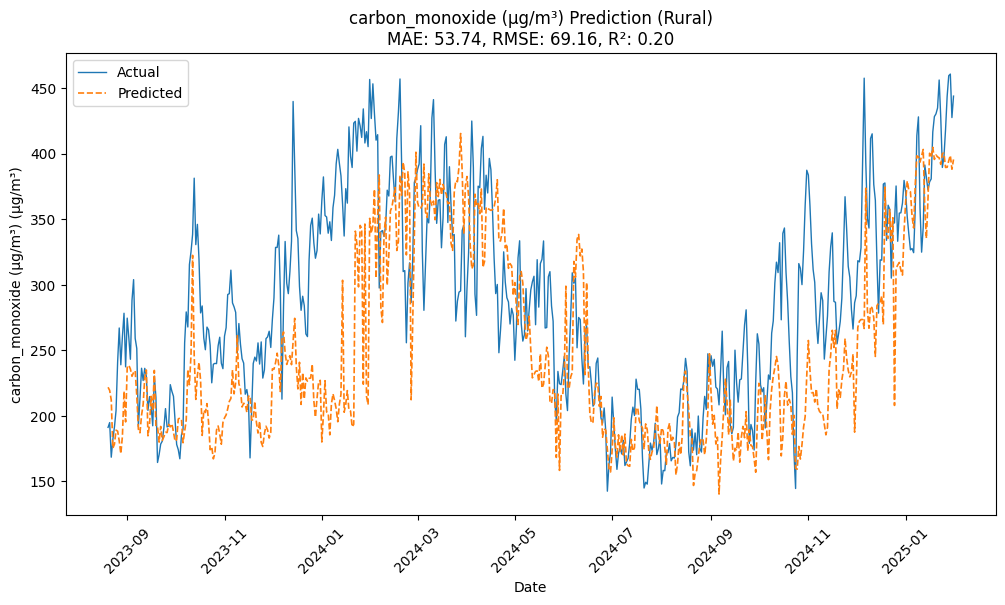

Training XGBoost Model for nitrogen_dioxide (μg/m³)...


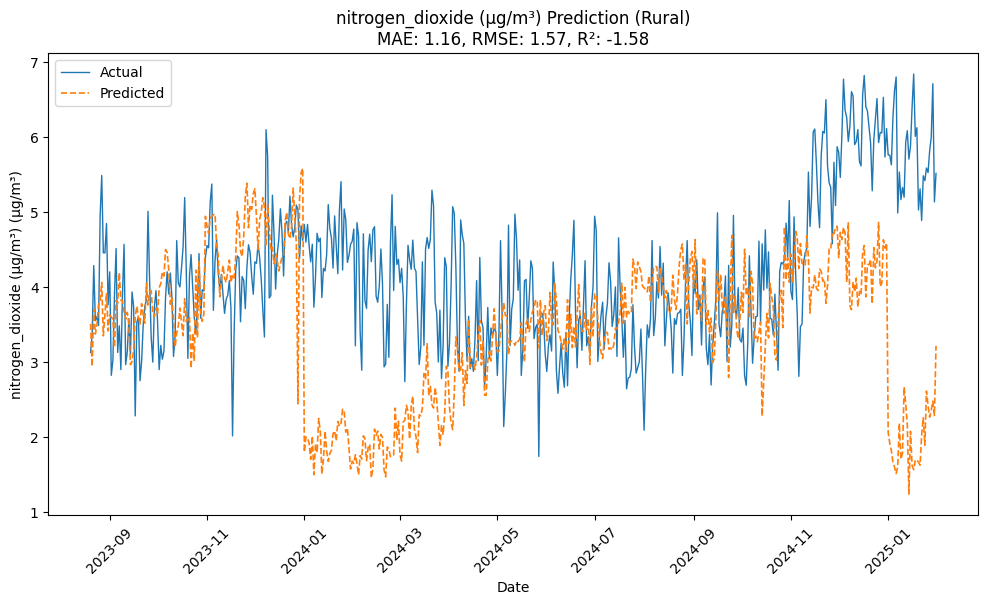

Training XGBoost Model for sulphur_dioxide (μg/m³)...


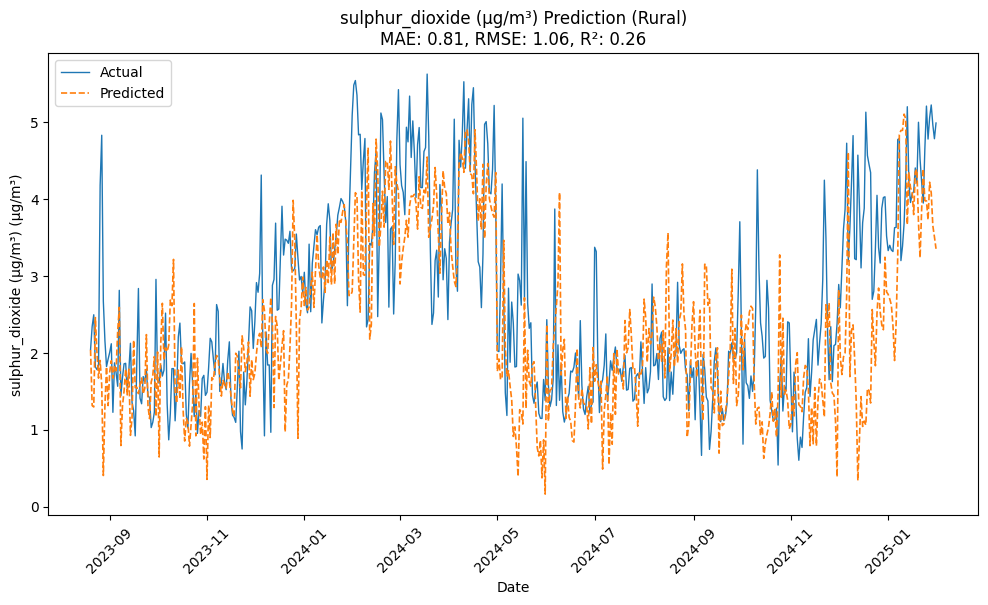

Training XGBoost Model for ozone (μg/m³)...


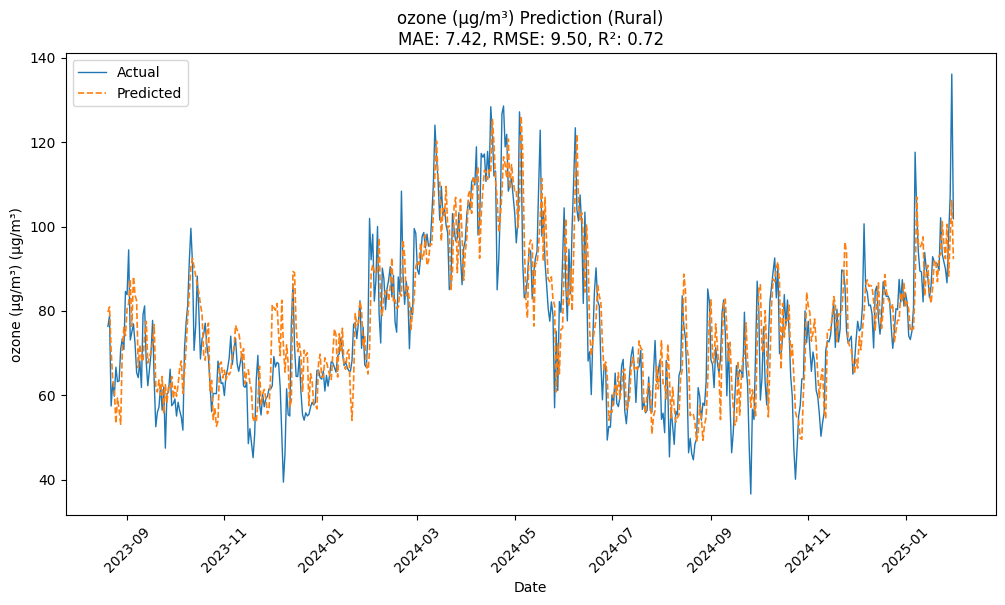


Analyzing Urban Areas
Training XGBoost Model for pm2_5 (μg/m³)...


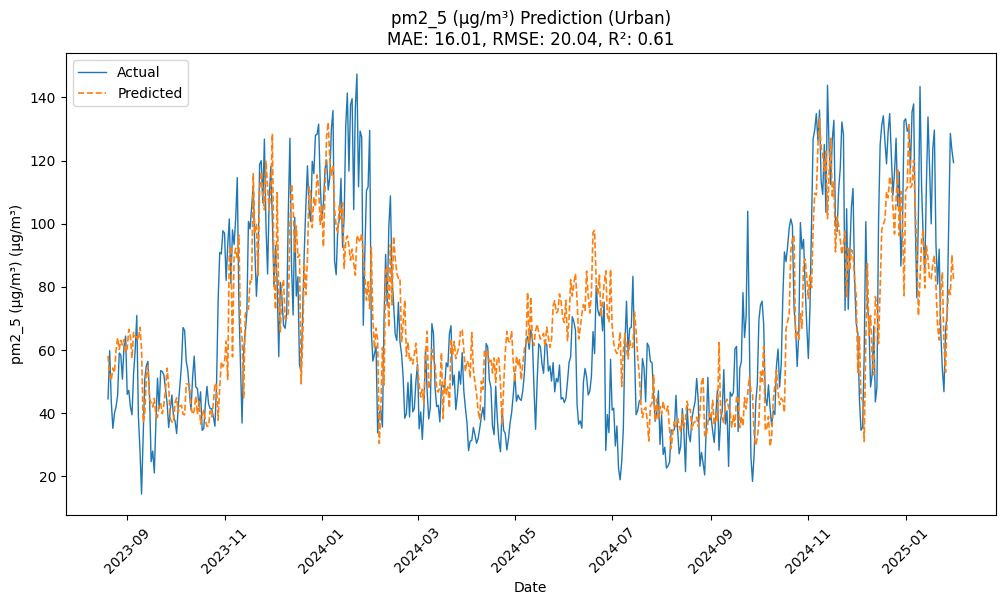

Training XGBoost Model for pm10 (μg/m³)...


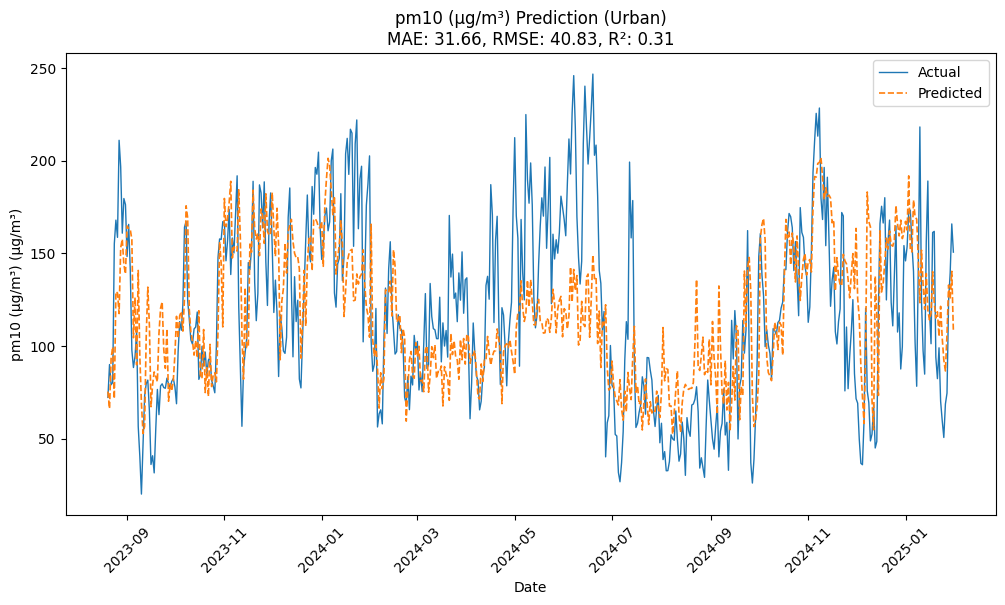

Training XGBoost Model for carbon_monoxide (μg/m³)...


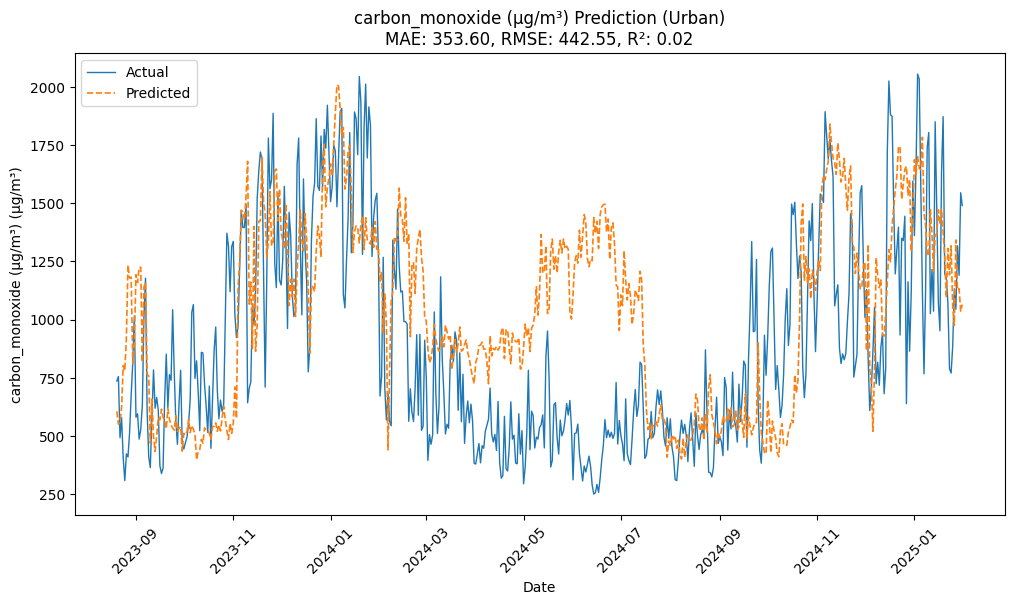

Training XGBoost Model for nitrogen_dioxide (μg/m³)...


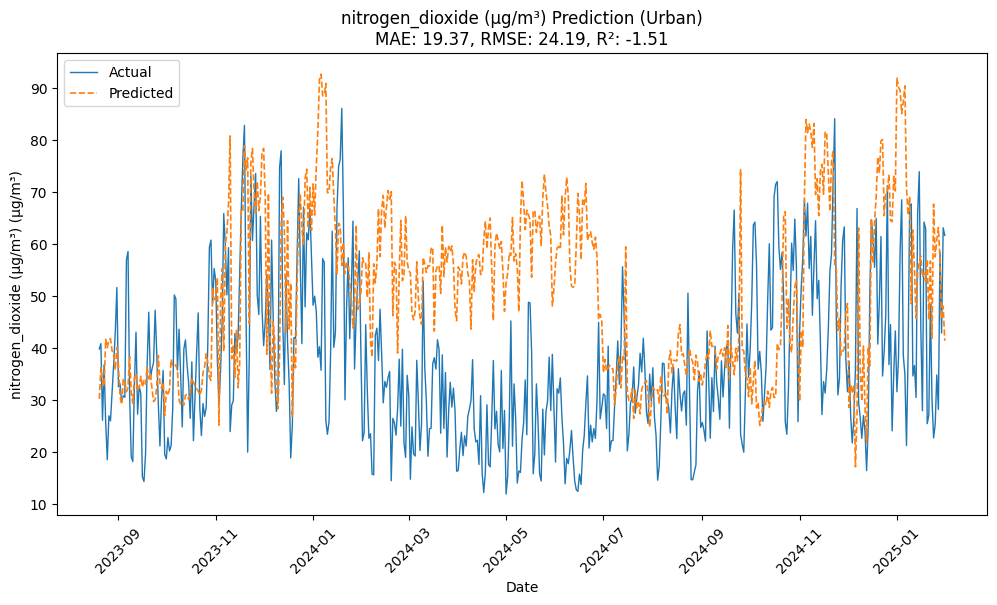

Training XGBoost Model for sulphur_dioxide (μg/m³)...


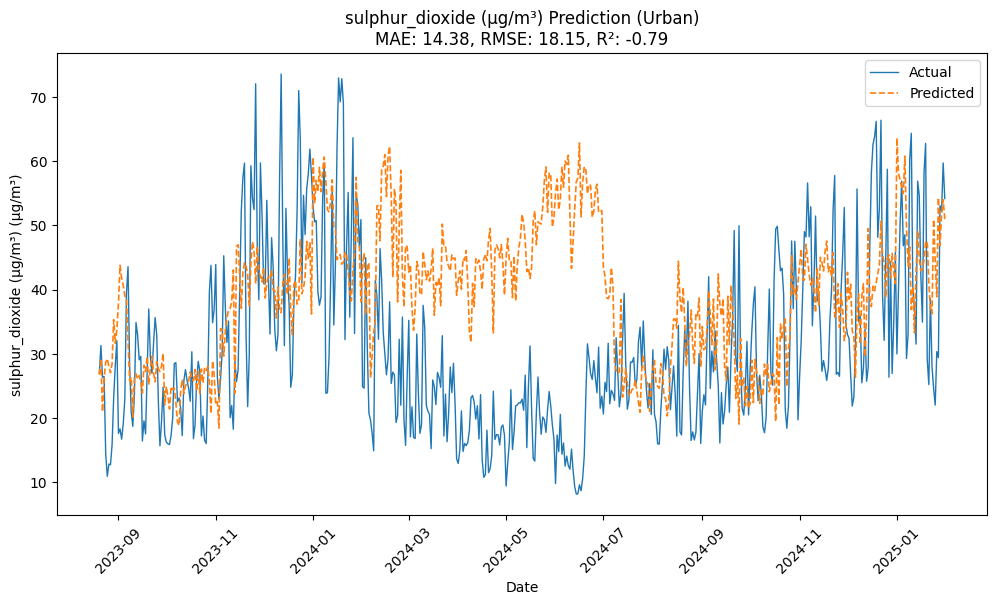

Training XGBoost Model for ozone (μg/m³)...


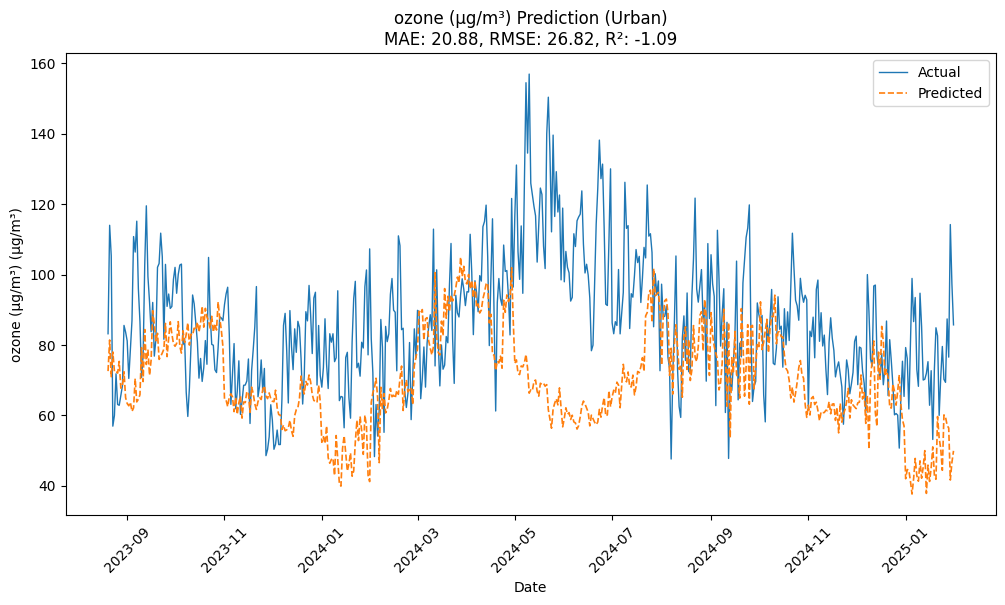

                                   MAE        RMSE        R2
0 pm2_5 (μg/m³)               6.657199    8.994661  0.477410
  pm10 (μg/m³)               10.403722   13.975485  0.437439
  carbon_monoxide (μg/m³)    53.740821   69.163350  0.195154
  nitrogen_dioxide (μg/m³)    1.163075    1.568067 -1.582542
  sulphur_dioxide (μg/m³)     0.805388    1.061811  0.259395
  ozone (μg/m³)               7.424650    9.500822  0.724836
1 pm2_5 (μg/m³)              16.011901   20.038395  0.607224
  pm10 (μg/m³)               31.655038   40.830954  0.309917
  carbon_monoxide (μg/m³)   353.598473  442.554570  0.019771
  nitrogen_dioxide (μg/m³)   19.371653   24.189171 -1.514400
  sulphur_dioxide (μg/m³)    14.376030   18.147354 -0.787164
  ozone (μg/m³)              20.883810   26.818323 -1.092657


In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load Data
data = pd.read_csv("..//data/featureddata/featured_daily.csv", parse_dates=["date"])

# Convert categorical features to numeric
data['Urban/Rural'] = data['Urban/Rural'].astype('category').cat.codes
data['Location'] = data['Location'].astype('category').cat.codes  # Encode locations

# Define target pollutants for modeling
pollutants = ['pm2_5 (μg/m³)', 'pm10 (μg/m³)', 'carbon_monoxide (μg/m³)',
              'nitrogen_dioxide (μg/m³)', 'sulphur_dioxide (μg/m³)', 'ozone (μg/m³)']

# Define features
features = ['Urban/Rural', 'Location', 'year', 'month', 'day', 'weekday',
            'AQI_lag_1', 'AQI_lag_7', 'AQI_lag_14', 'AQI_lag_30',
            'AQI_7day_avg', 'AQI_30day_avg']

# Store results
results = {}

# Analyze separately for urban and rural areas
for area in [0, 1]:  # 0 = Rural, 1 = Urban
    print(f"\nAnalyzing {'Urban' if area == 1 else 'Rural'} Areas")
    df_area = data[data['Urban/Rural'] == area]
    
    for pollutant in pollutants:
        print(f"Training XGBoost Model for {pollutant}...")
        
        # Drop NaN values for the current pollutant
        df = df_area.dropna(subset=[pollutant])
        
        # Define X and y
        X = df[features]
        y = df[pollutant]
        
        # Train-Test Split (Time-aware, no shuffle)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, shuffle=False)
        
        # Train XGBoost Model
        model = xgb.XGBRegressor(objective='reg:squarederror', 
                                 n_estimators=100, learning_rate=0.1, max_depth=6, 
                                 random_state=42)
        model.fit(X_train, y_train)
        
        # Predictions
        y_pred = model.predict(X_test)
        
        # Evaluation Metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        results[(area, pollutant)] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
        
        # Plot Predictions over Time
        plt.figure(figsize=(12, 6))
        plt.plot(df.iloc[-len(y_test):]['date'], y_test.values, label='Actual', linewidth=1)
        plt.plot(df.iloc[-len(y_test):]['date'], y_pred, linestyle='dashed', linewidth=1.2, label='Predicted')
        plt.legend()
        plt.title(f"{pollutant} Prediction ({'Urban' if area == 1 else 'Rural'})\nMAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")
        plt.xlabel("Date")
        plt.ylabel(f"{pollutant} (μg/m³)")
        plt.xticks(rotation=45)
        plt.show()

# Convert results to DataFrame for comparison
results_df = pd.DataFrame(results).T
print(results_df)


Decomposing trend for Urban areas - AQI


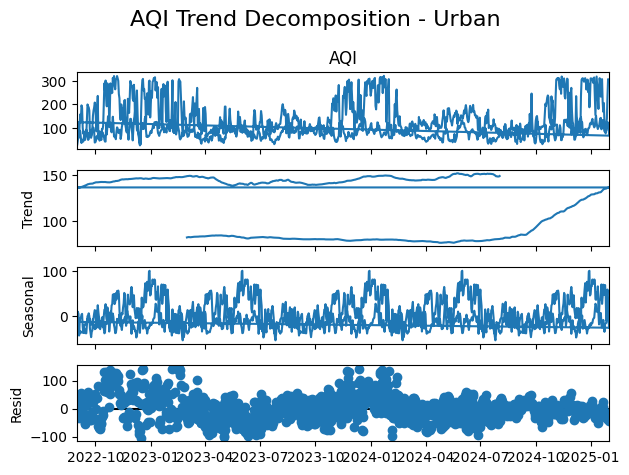


Decomposing trend for Rural areas - AQI


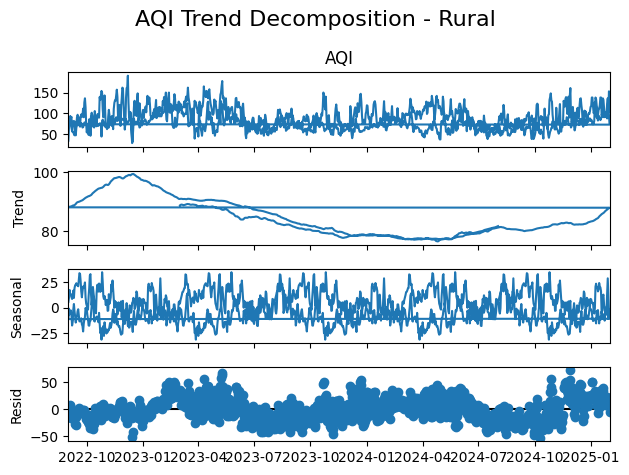


Decomposing trend for Urban areas - pm10 (μg/m³)


FileNotFoundError: [Errno 2] No such file or directory: '/workspaces/ProjectAir/plots/pm10 (μg/m³)_Urban_trend_decomposition.png'

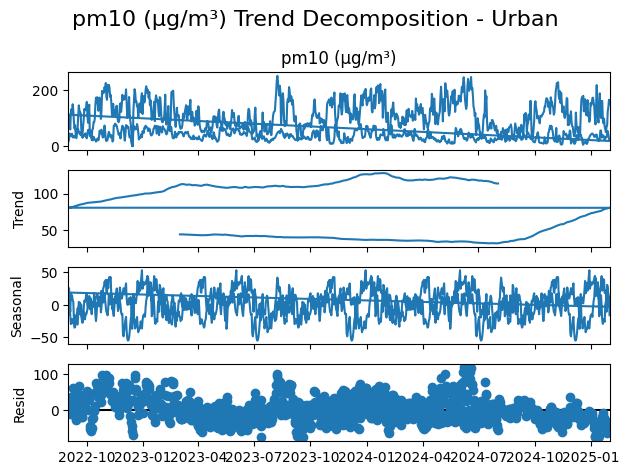

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Load dataset
file_path = '../data/featureddata/featured_daily.csv'  # Adjust path if needed
df = pd.read_csv(file_path)

# Ensure date column is datetime type
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Separate urban and rural data
urban_df = df[df['Urban/Rural'] == 'Urban']
rural_df = df[df['Urban/Rural'] == 'Rural']

# Function for trend decomposition
def decompose_trend(data, location_type, pollutant='AQI', model='additive'):
    print(f"\nDecomposing trend for {location_type} areas - {pollutant}")
    decomposition = seasonal_decompose(data[pollutant], model=model, period=365)
    decomposition.plot()
    plt.suptitle(f'{pollutant} Trend Decomposition - {location_type}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'../plots/{pollutant}_{location_type}_trend_decomposition.png')
    plt.show()

# Decompose AQI for urban and rural areas
decompose_trend(urban_df, 'Urban', 'AQI')
decompose_trend(rural_df, 'Rural', 'AQI')

# Analyze pollutant-specific trends for key pollutants
pollutants = ['pm10 (μg/m³)', 'pm2_5 (μg/m³)', 'carbon_monoxide (μg/m³)',
              'nitrogen_dioxide (μg/m³)', 'sulphur_dioxide (μg/m³)', 'ozone (μg/m³)']

for pollutant in pollutants:
    decompose_trend(urban_df, 'Urban', pollutant)
    decompose_trend(rural_df, 'Rural', pollutant)

# Yearly AQI Trend Analysis
df['year'] = df.index.year
yearly_trend = df.groupby(['year', 'Urban/Rural'])['AQI'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_trend, x='year', y='AQI', hue='Urban/Rural', marker='o')
plt.title('Yearly AQI Trend (Urban vs Rural)')
plt.xlabel('Year')
plt.ylabel('Average AQI')
plt.legend(title='Area Type')
plt.tight_layout()
plt.savefig('../plots/yearly_aqi_trend.png')
plt.show()

# Monthly AQI Trend Analysis
df['month'] = df.index.month
monthly_trend = df.groupby(['month', 'Urban/Rural'])['AQI'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_trend, x='month', y='AQI', hue='Urban/Rural', marker='o')
plt.title('Monthly AQI Trend (Urban vs Rural)')
plt.xlabel('Month')
plt.ylabel('Average AQI')
plt.legend(title='Area Type')
plt.tight_layout()
plt.savefig('../plots/monthly_aqi_trend.png')
plt.show()

# Weekday AQI Trend Analysis
df['weekday'] = df.index.weekday
weekday_trend = df.groupby(['weekday', 'Urban/Rural'])['AQI'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=weekday_trend, x='weekday', y='AQI', hue='Urban/Rural', marker='o')
plt.title('Weekday AQI Trend (Urban vs Rural)')
plt.xlabel('Weekday (0=Monday, 6=Sunday)')
plt.ylabel('Average AQI')
plt.legend(title='Area Type')
plt.tight_layout()
plt.savefig('../plots/weekday_aqi_trend.png')
plt.show()
